## Predicting illegal drug usage from personality traits and demographic info

### Abstract
Understanding the personality traits that are predictive of illegal drug usage is important for public health and guidence of policy-making. In Fehrman et al.(1), the authors collect survey data on demographic factors, personality traits, and drug usage, and then run several machine learning models to analyze the traits that are predictive of the usage of individual and clusters of drugs. In this project, I focused on individuals who have used drugs that are widely classified as illegal (mushrooms, ecstasy, cocaine, LSD, ketamine, heroin, and crack) at least once. Very few people will take any one of these drugs in their lifetime, so the type of person who would cross that threshold would be interesting to understand.

I ran logistic regression and decision tree classifier models, which exhibited similar test accuracy (~70%) to the models described in the paper. The logistic regression model demonstrated that the personality traits of sensation seeking and openness to experience, in addition to the demographic of men were the most predictive of illegal drug use. The decision tree classifier demonstrated that a branch of lower sensation seeking, lower openness, and higher conscientiousness was the most predictive of never using an illegal drug.

(1) https://arxiv.org/abs/1506.06297

### Introduction
The authors of the paper collected survey data on five demographic factors (age, gender, education, country, ethnicity) and seven personality traits (neuroticism, extraversion, openness to experience, agreeableness, conscientiousness from the Five Factor Model (2), and impulsivity and sensation seeking from two other personlity inventories). The Five Factor model is a well-validated metric of personality that has shown to be predictive of real-world outcomes in many studies. The impulsivity and sensation seeking metrics are specifically tailored to capture traits known to be associated with drug use. In addition to this, the authors collected data on the usage of 16 psychoactive substances (alcohol, amphetamines, amyl nitrite, benzodiazepines, caffeine, cannabis, cocaine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine, volatile substances), plus two controls (chocolate and a fictitious substance called semer). In the dataset provided by the UCI Machine Learning Repository (3), each feature was quantified and mean-centered. Some features were ordinal such as age (from bracket "18-24" to "65+"), education (from 
"Left school before 16 years" to "Doctorate"), and drug use (one of seven responses from "Never used" to "Used in the last day." Other features, such as country and ethnicity, were quantified, although the quantification is neccessarily arbitrary.

(2) https://www.annualreviews.org/doi/abs/10.1146/annurev.ps.41.020190.002221

(3) https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

### Related work and motivation
Related studies have used this dataset to examine features predictive of alcohol (4) and volatile substance (5) abuse. In this project, I decided not to focus on a single drug, but the usage of drugs that are widely classified as illegal. I also decided not to focus on when/how often drugs are used, but simply on if an individual used an illegal drug at least once. That is, I excluded legal drugs (alcohol, caffeine, cannabis, and nicotine), prescription drugs (amphetamines, benzodiazepines, and methadone), and drugs of little public interest (amyl nitrite, legal highs, and volatile substances). This leaves mushrooms, ecstasy, cocaine, LSD, ketamine, heroin, and crack as my drugs of interest. Ultimately, the question was: What demographic factors and personality traits are predicative of choosing to use an illegal drug in one's lifetime?

(4) https://link.springer.com/article/10.1007/s41870-018-0094-3

(5) https://ieeexplore.ieee.org/abstract/document/8234516

### Methods 1.1 Data loading

In [1]:
# Read csv
import pandas as pd
csv = pd.read_csv('Data/Drugs.csv', header = None)
print(csv.shape)

(1885, 31)


In [2]:
# Name columns
columns = ['Age', 'Female', 'Education', 'Country', 'Ethnicity', \
           'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', \
           'Impulsivity', 'SensationSeeking', \
           'Alcohol', 'Amphetamines', 'AmylNitrite', 'Benzodiazepines', 'Caffeine', 'Cannabis', 'Chocolate', \
           'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', \
           'Nicotine', 'Semer', 'VolatileSubstances']
print(len(columns))

31


In [3]:
# Create DataFrame
data = pd.DataFrame(data = csv)
data.columns = columns

### Methods 1.2 Data cleaning, manipulation, and exploration

In [4]:
# Drop multi-category, non-ordinal features
data = data.drop(['Country', 'Ethnicity'], axis = 1)

In [5]:
# Check value count for Semer, a fictitious drug included to weed out participants responding improperly
print(data.Semer.value_counts())
print(data.shape)
# Remove these rows
data = data[data['Semer'] == 0]
print(data.shape)
# Drop semer column
data = data.drop('Semer', axis = 1)

0    1877
2       3
3       2
1       2
4       1
Name: Semer, dtype: int64
(1885, 29)
(1877, 29)


In [6]:
# Name drug columns
drug_columns = ['Alcohol', 'Amphetamines', 'AmylNitrite', 'Benzodiazepines', 'Caffeine', 'Cannabis', 'Chocolate', \
           'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', \
           'Nicotine', 'VolatileSubstances']

In [7]:
# Convert drug use to binary (1 = used, 0 = never used)
for column in drug_columns:
    data[column].values[data[column].values > 0] = 1

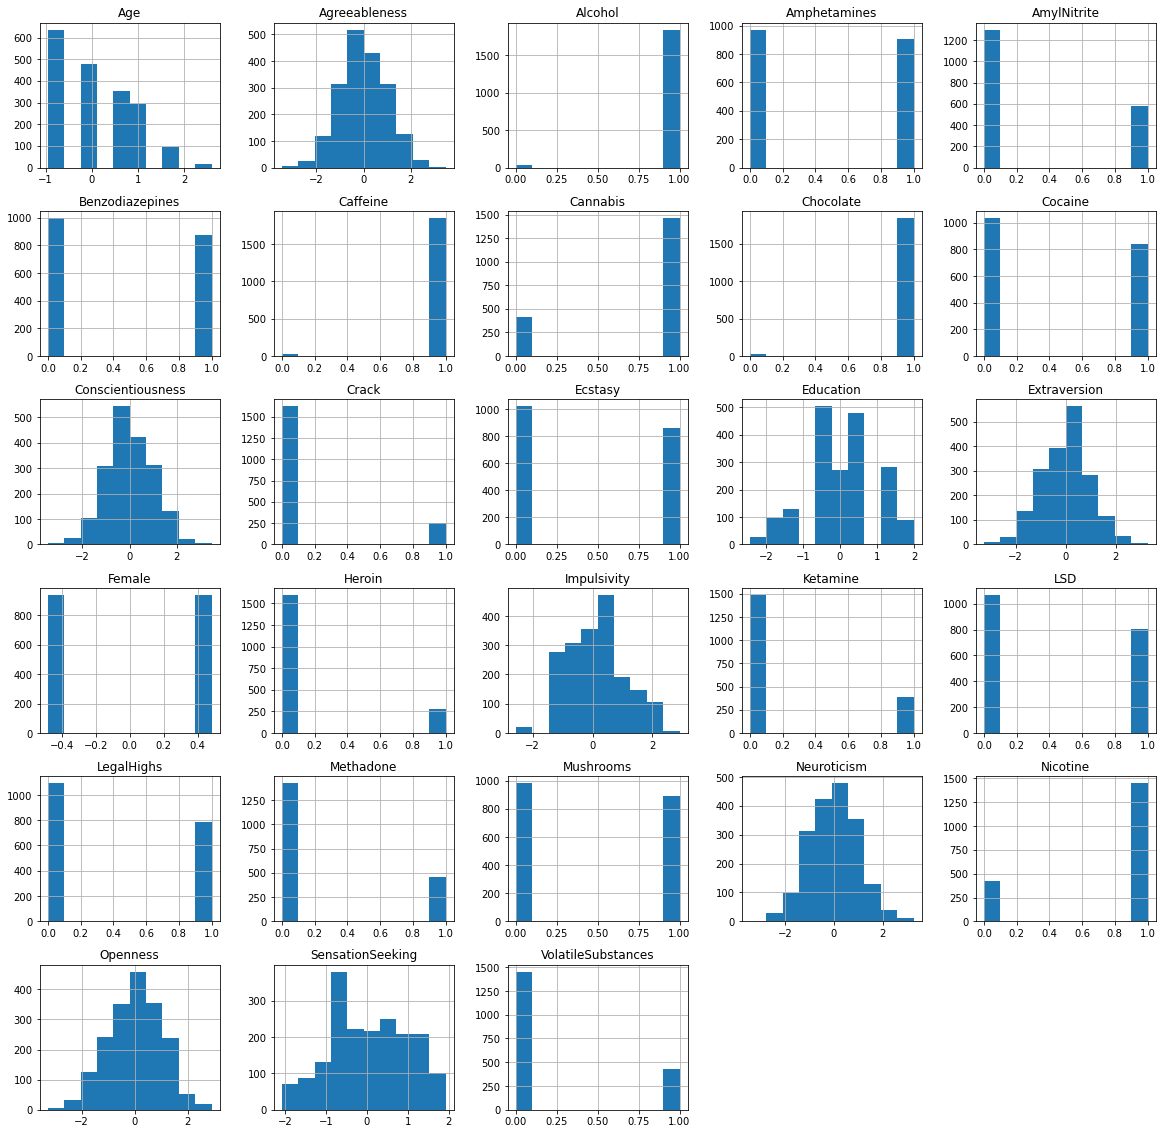

In [8]:
# Plot histograms
histograms = data.hist(bins = 10, figsize = (20, 20))

In [9]:
# Rank by usage
usage_list = []
for column in drug_columns:
    usage_list.append(data[column].mean())
usage_df = pd.DataFrame(columns = ['Drug', '% used'])
usage_df['Drug'] = drug_columns
usage_df['% used'] = usage_list
round(usage_df, 2).sort_values('% used', ascending = False)

,Drug,% used
4,Caffeine,0.99
0,Alcohol,0.98
6,Chocolate,0.98
5,Cannabis,0.78
16,Nicotine,0.77
1,Amphetamines,0.48
15,Mushrooms,0.48
3,Benzodiazepines,0.47
9,Ecstasy,0.46
7,Cocaine,0.45


In [10]:
# Create column for participants who have used one or more illegal drugs
pd.options.mode.chained_assignment = None
illegal_drugs = ['Mushrooms', 'Ecstasy', 'Cocaine', 'LSD', 'Ketamine', 'Heroin', 'Crack']
illegal_drugs_df = data[illegal_drugs]
illegal_drugs_df['UsedIllegalDrug'] = illegal_drugs_df.sum(axis = 1)
# If the sum of single use of any illegal drug > 0, then UsedIllegalDrug = 1
illegal_drugs_df['UsedIllegalDrug'][illegal_drugs_df['UsedIllegalDrug'] > 0] = 1
# Percent of participants who have used each drug at least once 
# + percent of participants who have used one or more of these drugs at least once
round(illegal_drugs_df.mean(), 2)

Mushrooms          0.48
Ecstasy            0.46
Cocaine            0.45
LSD                0.43
Ketamine           0.21
Heroin             0.15
Crack              0.14
UsedIllegalDrug    0.64
dtype: float64

In [11]:
# Add column to main data
data['UsedIllegalDrug'] = illegal_drugs_df['UsedIllegalDrug']
# Drop columns not of interest
data_illegaldrugs = data[['Age', 'Female', 'Education', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', \
            'Conscientiousness', 'Impulsivity', 'SensationSeeking', 'UsedIllegalDrug']]

In [12]:
# Group by illegal drug use
grouped = round(data_illegaldrugs.groupby('UsedIllegalDrug').mean(), 2)
grouped

,Age,Female,Education,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsivity,SensationSeeking
UsedIllegalDrug,,,,,,,,,,
0,0.33,0.17,0.20,-0.15,0.03,-0.46,0.21,0.35,-0.38,-0.54
1,-0.13,-0.09,-0.12,0.08,-0.02,0.25,-0.12,-0.20,0.22,0.30


In [13]:
# Calculate largest differences in features between groups
difference = grouped.iloc[0] - grouped.iloc[1]
difference.sort_values()
# Non-users are less sensation seeking, more consciousness, etc.

SensationSeeking    -0.84
Openness            -0.71
Impulsivity         -0.60
Neuroticism         -0.23
Extraversion         0.05
Female               0.26
Education            0.32
Agreeableness        0.33
Age                  0.46
Conscientiousness    0.55
dtype: float64

In [14]:
# Group by gender
grouped = round(data_illegaldrugs.groupby('Female').mean(), 2)
grouped

,Age,Education,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsivity,SensationSeeking,UsedIllegalDrug
Female,,,,,,,,,,
-0.48246,-0.06,-0.19,-0.07,-0.06,0.13,-0.22,-0.18,0.17,0.23,0.76
0.48246,0.13,0.19,0.07,0.06,-0.14,0.22,0.18,-0.16,-0.24,0.51


In [15]:
# Calculate largest differences in features between groups
difference = grouped.iloc[0] - grouped.iloc[1]
difference.sort_values()
# Men are less agreeable, less educated, more impulsive, more sensation seeking, etc.

Agreeableness       -0.44
Education           -0.38
Conscientiousness   -0.36
Age                 -0.19
Neuroticism         -0.14
Extraversion        -0.12
UsedIllegalDrug      0.25
Openness             0.27
Impulsivity          0.33
SensationSeeking     0.47
dtype: float64

In [16]:
# Separate features from target
X = data_illegaldrugs.drop('UsedIllegalDrug', axis = 1)
y = data_illegaldrugs['UsedIllegalDrug']

In [17]:
# Examine multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame(columns = ['Features', 'VIF'])
vif['Features'] = X.columns
for i in range(X.shape[1]):
    vif.loc[i, 'VIF'] = variance_inflation_factor(X.values, i).round(1)
# Remove constant row
vif = vif[1:]
# Sort by VIF
vif.sort_values('VIF', ascending = False)
# No VIF > 5

,Features,VIF
9,SensationSeeking,2.1
8,Impulsivity,1.8
3,Neuroticism,1.5
4,Extraversion,1.5
7,Conscientiousness,1.5
5,Openness,1.3
1,Female,1.2
6,Agreeableness,1.2
2,Education,1.1


In [18]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20201011)
print(X_train.shape)
print(X_test.shape)

(1501, 10)
(376, 10)


### Methods 2.1 Logistic regression

In [19]:
# Run logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
columns = X_train.columns
coefs = model.coef_.round(2)

In [20]:
# Sort features by beta value
feature_coefs = pd.DataFrame(columns = ['Feature', 'Beta'])
feature_coefs['Feature'] = columns
feature_coefs['Beta'] = coefs[0]
feature_coefs.sort_values('Beta')

,Feature,Beta
1,Female,-0.53
7,Conscientiousness,-0.31
2,Education,-0.24
0,Age,-0.23
4,Extraversion,-0.21
6,Agreeableness,-0.09
3,Neuroticism,-0.03
8,Impulsivity,-0.03
5,Openness,0.68
9,SensationSeeking,0.72


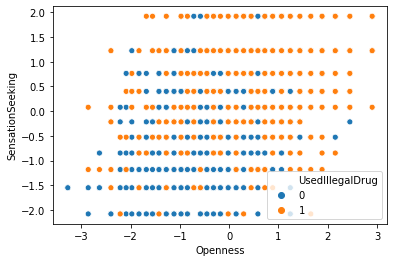

In [21]:
# Plot illegal drug use vs. largest betas
import seaborn as sns
sns.scatterplot(x = "Openness", y = "SensationSeeking", data = data, hue = 'UsedIllegalDrug')

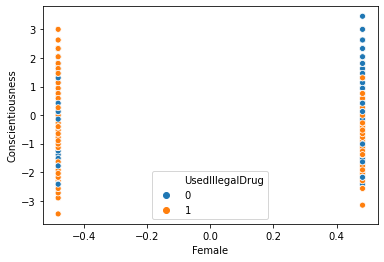

In [22]:
# Plot illegal drug use vs. smallest betas
sns.scatterplot(x = "Female", y = "Conscientiousness", data = data, hue = 'UsedIllegalDrug')

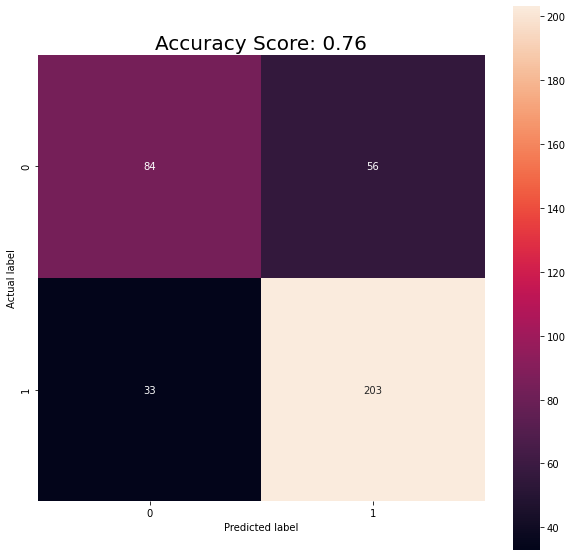

In [23]:
# Plot confusion matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
score = round(metrics.accuracy_score(y_test, y_pred),2)
title = 'Accuracy Score: {0}'.format(score)
plt.title(title, size = 20);
plt.show()

### Methods 2.2 Decision tree classifier

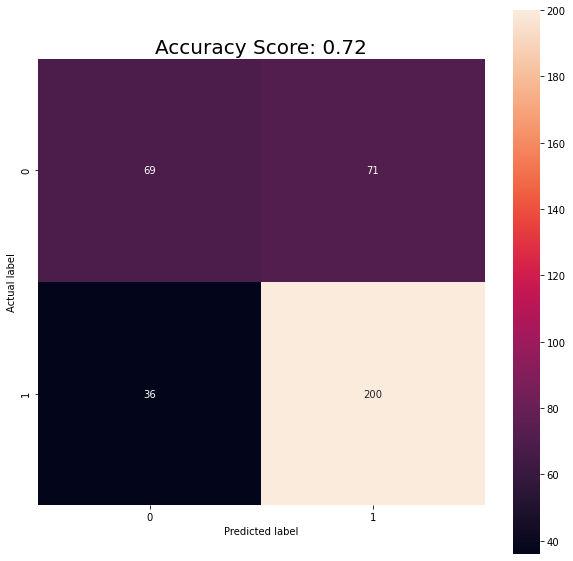

In [24]:
# Run DecisionTreeClassifier with max_depth = 3
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth = 3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
score = round(metrics.accuracy_score(y_test, y_pred),2)
title = 'Accuracy Score: {0}'.format(score)
plt.title(title, size = 20);
plt.show()

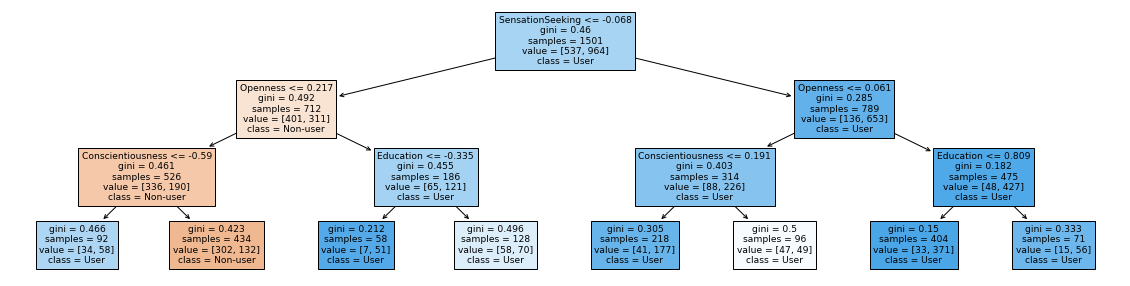

In [25]:
# Plot tree
fig = plt.figure(figsize=(20, 5))
_ = tree.plot_tree(model, 
                   feature_names = X.columns,  
                   class_names = ['Non-user', 'User'],
                   filled = True)

### Results and discussion
Of the illegal drugs, mushrooms and ecstasy were the most used, heroin and crack were the least used. 64% of participants had used at least one illegal drug. The biggest differences between the group of participants who had used an illegal drug and the group who had never used an illegal drug were that users scored higher on sensation seeking and openness while non-users scored higher on conscientiousness and were older. 

However, when modeled as a multiple logistic regression, gender (being female) was the largest predictor of being a non-user. In the scatterplots of the largest positive and negative betas, users concentrate in the top right corner of high sensation seeking and openness; in the conscientiousness x gender plot, it appears that males of all conscientiousness levels have used an illegal drug, while there is a cluster of high conscientiousness females who have never used an illegal drug. This may suggest an interaction effect between the conscientiousness and gender features. The logistic regression model predicted illegal drug use with 76% accuracy in the test set, with more false positives for being a user (n = 56) than false negatives for being a non-user (n = 33). 

The decision tree classifier model was less successful than the logistic regression model with 72% accuracy in the test set. The tree created by the classifier demonstrated that a branch of lower sensation seeking, lower openness, and higher conscientiousness was the most predictive of never using an illegal drug. All other leaves classified an observation as a user.

### Conclusion and summary
Overall, the results of this project appear to align with published literature and our intuitions of how demographics and personality would impact illegal drug use. Individuals who use an illegal drug in their lifetime tend to be male, score higher on sensation seeking and openness, and lower on conscientiousness.

### Limitations and later work
Given the extremely high usage (~15%) of drugs like heroin and crack, it is clear that the participants of this survey are not representative of the general population. The paper reports that the participants were largely English-speaking, highly educated, and white. Also, because there is no data on the life outcomes of the participants, we cannot conclude that the usage of these illegal drugs is deleterious, and therefore, we cannot conclude that having the associated personality traits is undesirable. 

In later work with this dataset, I am interested in looking at the drugs individually, and also in groupings other than just illegal drugs. For instance, we know that while mushrooms, ecstasy, cocaine, LSD, ketamine, heroin, and crack are all illegal, it is heroin and crack that are known to be strongly associated with deleterious life outcomes. 

Below, you will find the preliminary results of an analysis of the totals, percentages, accuracies, intercepts, minimum, and maximum betas for multiple logistic regression models run on each drug individually, with the target variable being "Used within the last year." It is important to note here that the high accuracy metrics for crack and chocolate are not very meaningful, since very few participants and almost all participants used crack and chocolate within the last year, respectively. In these cases of class inbalance, most of the work is accomplished by the intercept value. Measures more sophisticated than accuracy must then be used to evaluate model performance. However, in this preliminary analysis, you can already see that there is differential association of certain drugs with openness, sensation seeking, neuroticism, impulsivity, etc.

In [26]:
# Read csv
import pandas as pd
csv = pd.read_csv('Data/Drugs.csv', header = None)
# Name columns
columns = ['Age', 'Female', 'Education', 'Country', 'Ethnicity', \
           'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', 'Conscientiousness', \
           'Impulsivity', 'SensationSeeking', \
           'Alcohol', 'Amphetamines', 'AmylNitrite', 'Benzodiazepines', 'Caffeine', 'Cannabis', 'Chocolate', \
           'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'LegalHighs', 'LSD', 'Methadone', 'Mushrooms', \
           'Nicotine', 'Semer', 'VolatileSubstances']
# Create DataFrame
data = pd.DataFrame(data = csv)
data.columns = columns
# Drop multi-category, non-ordinal features
data = data.drop(['Country', 'Ethnicity'], axis = 1)
# Check value count for Semer, a fictitious drug included to weed out participants responding improperly
# Remove these rows
data = data[data['Semer'] == 0]
# Drop semer column
data = data.drop('Semer', axis = 1)

In [27]:
# For loop calculations for each drug
drug_name = []
total = []
percent = []
accuracy = []
intercept = []
min_beta_name = []
min_beta = []
max_beta_name = []
max_beta = []
for i, drug in enumerate(drug_columns):
    drug_df = data[data.columns[i + 10]]
    drug_df['UsedDrug'] = drug_df > 2 # yearly vs. non-yearly users
    # Add column to main data
    data['UsedDrug'] = drug_df['UsedDrug']
    # Drop columns not of interest
    data_drug = data[['Female', 'Education', 'Neuroticism', 'Extraversion', 'Openness', 'Agreeableness', \
                'Conscientiousness', 'Impulsivity', 'SensationSeeking', 'UsedDrug']]
    # Separate features from target
    X = data_drug.drop('UsedDrug', axis = 1)
    y = data_drug['UsedDrug']
    # Train test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20201011)
    # Run logistic regression
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    columns = X_train.columns
    coefs = model.coef_.round(2)
    # Sort features by beta value
    feature_coefs = pd.DataFrame(columns = ['Feature', 'Beta'])
    feature_coefs['Feature'] = columns
    feature_coefs['Beta'] = coefs[0]
    drug_name.append(drug)
    total.append(sum(drug_df['UsedDrug']))
    percent.append(round(sum(drug_df['UsedDrug'])/len(drug_df['UsedDrug']), 2))
    accuracy.append(round(metrics.accuracy_score(y_test, y_pred),2))
    intercept.append(round(model.intercept_[0],2))
    min_beta_name.append(feature_coefs.sort_values('Beta').iloc[0][0])
    min_beta.append(feature_coefs.sort_values('Beta').iloc[0][1])
    max_beta_name.append(feature_coefs.sort_values('Beta', ascending = False).iloc[0][0])
    max_beta.append(feature_coefs.sort_values('Beta', ascending = False).iloc[0][1])

In [28]:
# Create data frame
results = pd.DataFrame({'Drug': drug_name, 'Total': total, 'Accuracy': accuracy, 'Percent': percent, \
                        'Intercept': intercept, \
                        'Min Beta Name': min_beta_name, 'Min Beta': min_beta, \
                        'Max Beta Name': max_beta_name, 'Max Beta': max_beta})
results.sort_values('Accuracy')

,Drug,Total,Accuracy,Percent,Intercept,Min Beta Name,Min Beta,Max Beta Name,Max Beta
16,Nicotine,1053,0.68,0.56,0.31,Female,-0.41,SensationSeeking,0.46
3,Benzodiazepines,532,0.72,0.28,-1.14,Female,-0.36,Neuroticism,0.44
1,Amphetamines,433,0.74,0.23,-1.61,Female,-0.70,SensationSeeking,0.49
9,Ecstasy,513,0.75,0.27,-1.24,Female,-0.60,SensationSeeking,0.69
15,Mushrooms,428,0.77,0.23,-1.67,Female,-0.80,Openness,0.75
5,Cannabis,991,0.77,0.53,0.17,Female,-0.72,Openness,0.85
7,Cocaine,414,0.77,0.22,-1.52,Female,-0.53,SensationSeeking,0.55
12,LegalHighs,561,0.77,0.30,-1.22,Female,-0.89,SensationSeeking,0.76
13,LSD,376,0.81,0.20,-1.86,Female,-0.90,Openness,0.79
14,Methadone,319,0.82,0.17,-1.99,Female,-0.70,Openness,0.49
